# CM09 - decision trees - oefening 2

In dit notebook wordt het onderliggende zelflerende algoritme van decision trees uitgelegd. Dit is gebaseerd op entropie. Je kunt in dit notebook zelf spelen met de werking van entropie om zo een beter gevoel te krijgen voor de werking van decision trees.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import scipy.stats as st

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
weer = pd.DataFrame({'weertype': ['slecht', 'slecht', 'slecht', 'medium', 'mooi', 'medium', 'mooi'],
                     'weerklasse': [0, 0, 0, 1, 2, 1, 2],
                     'temperatuur': [3, 18, 32, 36, 19, 7, -10], 
                     'regen': [True, True, True, False, False, False, False]})

Entropie $E(S)$:

$$E(S) = -\sum_{i=1}^{c}p_{i}\log_{2}(p_{i})$$

Als er twee klassen zijn (dus $c = 2$ mogelijke waarden voor doelvariabele $S$), dan ligt de waarde van de entropie tussen de 0 (alles behoort tot één klasse) en 1 (meetwaarden zijn precies verdeeld over de twee klassen).

NB. Als je het aandeel $p_1$ van de eerste klasse $c_1$ weet, dan weet je ook het aandeel $p_2 = 1 - p_1$ van de tweede klasse $c_2$. Bij méér dan twee klassen gaat dit natuurlijk niet meer op.

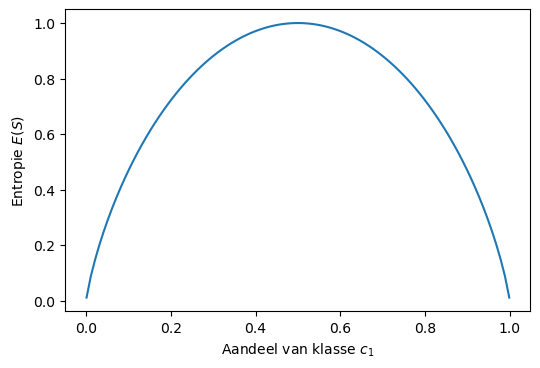

In [3]:
fig, ax = plt.subplots(1, dpi=100)

x = np.linspace(.001,.999,100)
y = -x * np.log2(x) + -(1-x) * np.log2(1-x)
ax.set_xlabel(r"Aandeel van klasse $c_1$")
ax.set_ylabel(r"Entropie $E(S)$")

plt.plot(x,y)
plt.show()

Bepaal met bovenstaande formule de entropie van doelvariabele `weertype`.

In [4]:
weer

,weertype,weerklasse,temperatuur,regen
0,slecht,0,3,True
1,slecht,0,18,True
2,slecht,0,32,True
3,medium,1,36,False
4,mooi,2,19,False
5,medium,1,7,False
6,mooi,2,-10,False


In [5]:
# Entropie voor weertype [slecht, medium, mooi]
# Berekening 1
E_weertype = - ((3/7) * np.log2(3/7) + (2/7) * np.log2(2/7) + (2/7) * np.log2(2/7))
E_weertype

1.5566567074628228

In [6]:
# Berekening 2
st.entropy([3,2,2], base=2)

1.556656707462823

In [7]:
# Berekening 3
st.entropy(weer.groupby('weertype').count()['weerklasse'], base=2)

1.556656707462823

### Split 1. Regen of temperatuur?

Bereken de entropie en information gain bij een split op `regen`.

In [8]:
weer_regen_false = weer[weer.regen == False]
weer_regen_false

,weertype,weerklasse,temperatuur,regen
3,medium,1,36,False
4,mooi,2,19,False
5,medium,1,7,False
6,mooi,2,-10,False


In [9]:
# Entropie bij regen = False
E_split1_regen_false = st.entropy([0,2,2], base=2)
E_split1_regen_false

1.0

In [10]:
weer[weer.regen == True]

,weertype,weerklasse,temperatuur,regen
0,slecht,0,3,True
1,slecht,0,18,True
2,slecht,0,32,True


In [11]:
# Entropie bij regen = True
E_split1_regen_true = st.entropy([3,0,0], base=2)
E_split1_regen_true

0.0

In [12]:
# Totale entropie na split op regen (gewogen gemiddelde)
E_split1_regen = 3/7*st.entropy([3,0,0], base=2) + 4/7*st.entropy([0,2,2], base=2)

# Information gain
gain_split1_regen = E_weertype - E_split1_regen

print(f"Entropie na een split op regen: {E_split1_regen:.2f}")
print(f"Information gain bij een split op regen: {gain_split1_regen:.2f}")

Entropie na een split op regen: 0.57
Information gain bij een split op regen: 0.99


We kunnen ook splitten op `temperatuur` op veel verschillende manieren. Bereken alleen de entropie en de information gain bij een split op `temperatuur` bij 20 graden.

In [13]:
weer[weer.temperatuur <= 20]

,weertype,weerklasse,temperatuur,regen
0,slecht,0,3,True
1,slecht,0,18,True
4,mooi,2,19,False
5,medium,1,7,False
6,mooi,2,-10,False


In [14]:
weer[weer.temperatuur > 20]

,weertype,weerklasse,temperatuur,regen
2,slecht,0,32,True
3,medium,1,36,False


In [15]:
# Totale entropie na split op 20 graden
E_split1_t20 = 5/7 * st.entropy([2,1,2], base=2) + 2/7 * st.entropy([1,1,0], base=2)
gain_split1_t20 = E_weertype - E_split1_t20

print(f"Entropie na een split op temperatuur == 20: {E_split1_t20:.2f}")
print(f"Information gain bij een split op temperatuur == 20: {gain_split1_t20:.2f}")

Entropie na een split op temperatuur == 20: 1.37
Information gain bij een split op temperatuur == 20: 0.18


Welke split is het beste?

Bij een split op regen, want de information gain is daar hoger dan bij een split op temperatuur = 20 graden. Dit geldt overigens voor alle splits op temperatuur.

### Split 2. Welke temperatuur?

Bereken ná een split op `regen` (dus als tweede laag) de entropie bij een split op `temperatuur` met de scheiding bij $t = 0$, $t = 10$ en $t = 20$ graden.

We hoeven alleen maar te kijken naar het restant van de dataset met géén regen, want het deel met wél regen heeft al een entropie van 0 en verdere opsplitsing heeft dus geen zin (verdere afname van entropie is niet mogelijk).

In [16]:
weer_regen_false

,weertype,weerklasse,temperatuur,regen
3,medium,1,36,False
4,mooi,2,19,False
5,medium,1,7,False
6,mooi,2,-10,False


In [17]:
weer_regen_false[weer_regen_false.temperatuur <= 20]

,weertype,weerklasse,temperatuur,regen
4,mooi,2,19,False
5,medium,1,7,False
6,mooi,2,-10,False


In [18]:
weer_regen_false[weer_regen_false.temperatuur > 20]

,weertype,weerklasse,temperatuur,regen
3,medium,1,36,False


In [19]:
# Entropie na split op 20 graden (split op 0 graden heeft dezelfde uitkomst)
E_split2_t20 = 3/4 * st.entropy([0,1,2], base=2) + 1/4 * st.entropy([0,1,0], base=2)
gain_split2_t20 = E_split1_regen_false - E_split2_t20

print(f"Entropie na een split op temperatuur == 20: {E_split2_t20:.2f}")
print(f"Information gain bij een split op temperatuur == 20: {gain_split2_t20:.2f}")

Entropie na een split op temperatuur == 20: 0.69
Information gain bij een split op temperatuur == 20: 0.31


In [20]:
weer_regen_false[weer_regen_false.temperatuur <= 10]

,weertype,weerklasse,temperatuur,regen
5,medium,1,7,False
6,mooi,2,-10,False


In [21]:
weer_regen_false[weer_regen_false.temperatuur > 10]

,weertype,weerklasse,temperatuur,regen
3,medium,1,36,False
4,mooi,2,19,False


In [22]:
# Entropie na split op 10 graden
E_split2_t10 = 2/4 * st.entropy([0,1,1], base=2) + 2/4 * st.entropy([0,1,1], base=2)
gain_split2_t10 = E_split1_regen_false - E_split2_t10

print(f"Entropie na een split op temperatuur == 10: {E_split2_t10:.2f}")
print(f"Information gain bij een split op temperatuur == 10: {gain_split2_t10:.2f}")

Entropie na een split op temperatuur == 10: 1.00
Information gain bij een split op temperatuur == 10: 0.00


Welke split is het beste?

Bij een split op 0 of 20 graden, want de information gain is daar hoger dan bij een split op temperatuur = 10 graden.

## Decision Tree

Maak de decision tree met `DecisionTreeClassifier`. Kies als parameter `criterion='entropy'`.

In [23]:
labels = dict(zip(weer['weerklasse'].unique(), weer['weertype'].unique()))
labels

{0: 'slecht', 1: 'medium', 2: 'mooi'}

In [24]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=2)
model.fit(weer[['regen', 'temperatuur']], weer['weerklasse'])

DecisionTreeClassifier(criterion='entropy', max_depth=2)

Visualisatie van de decision tree met GraphViz.

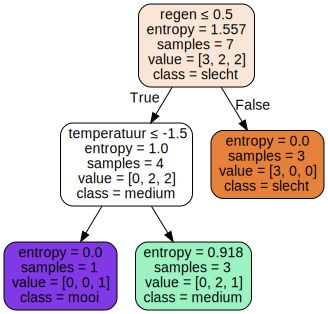

In [25]:
data = export_graphviz(model, out_file=None, feature_names=['regen', 'temperatuur'], class_names=labels,   
                         filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(data)
graph